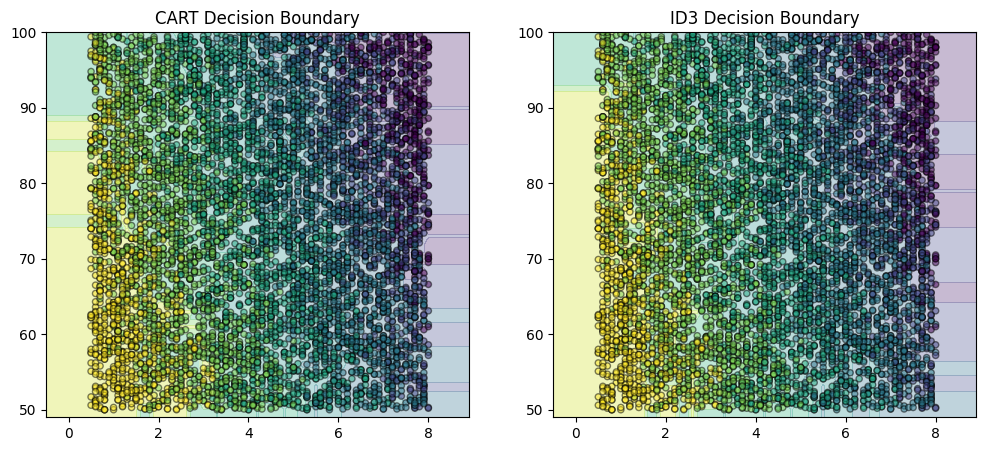

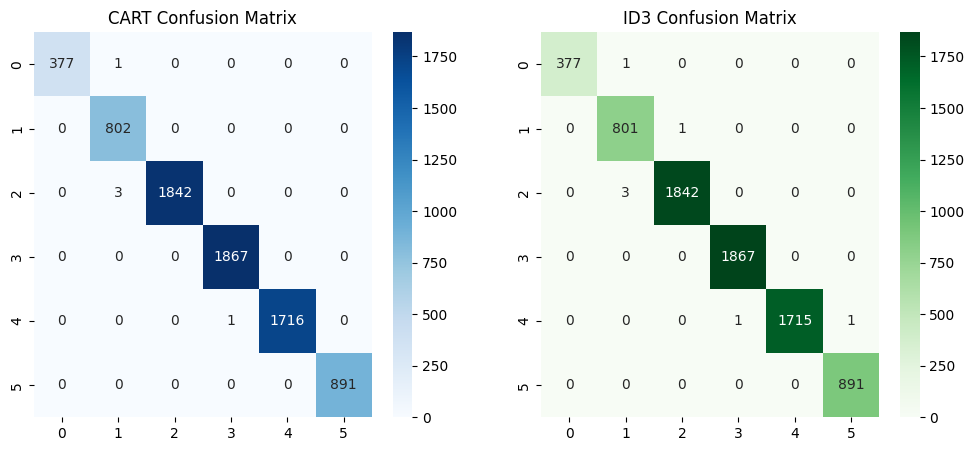

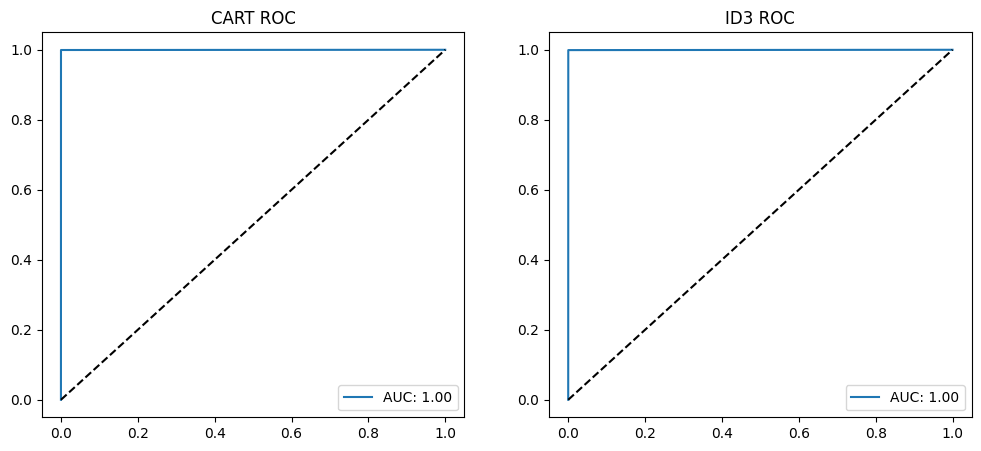

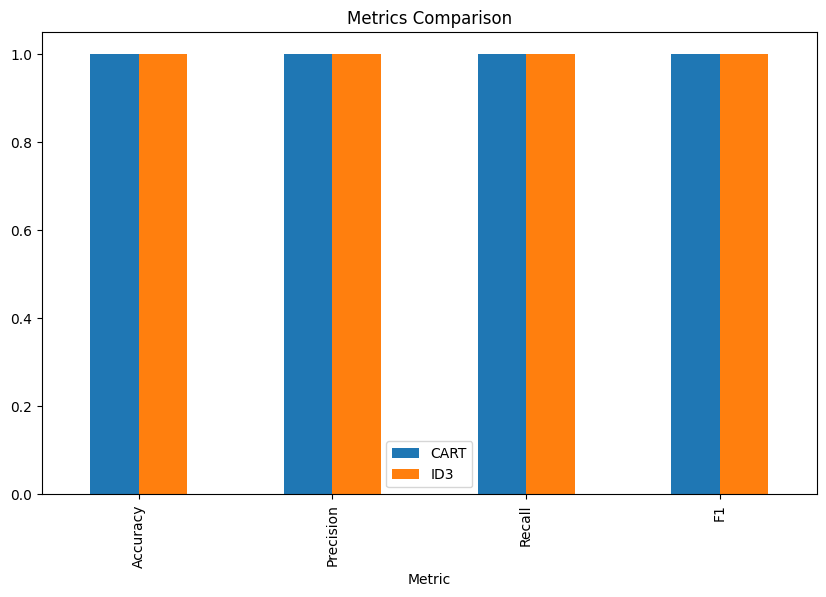

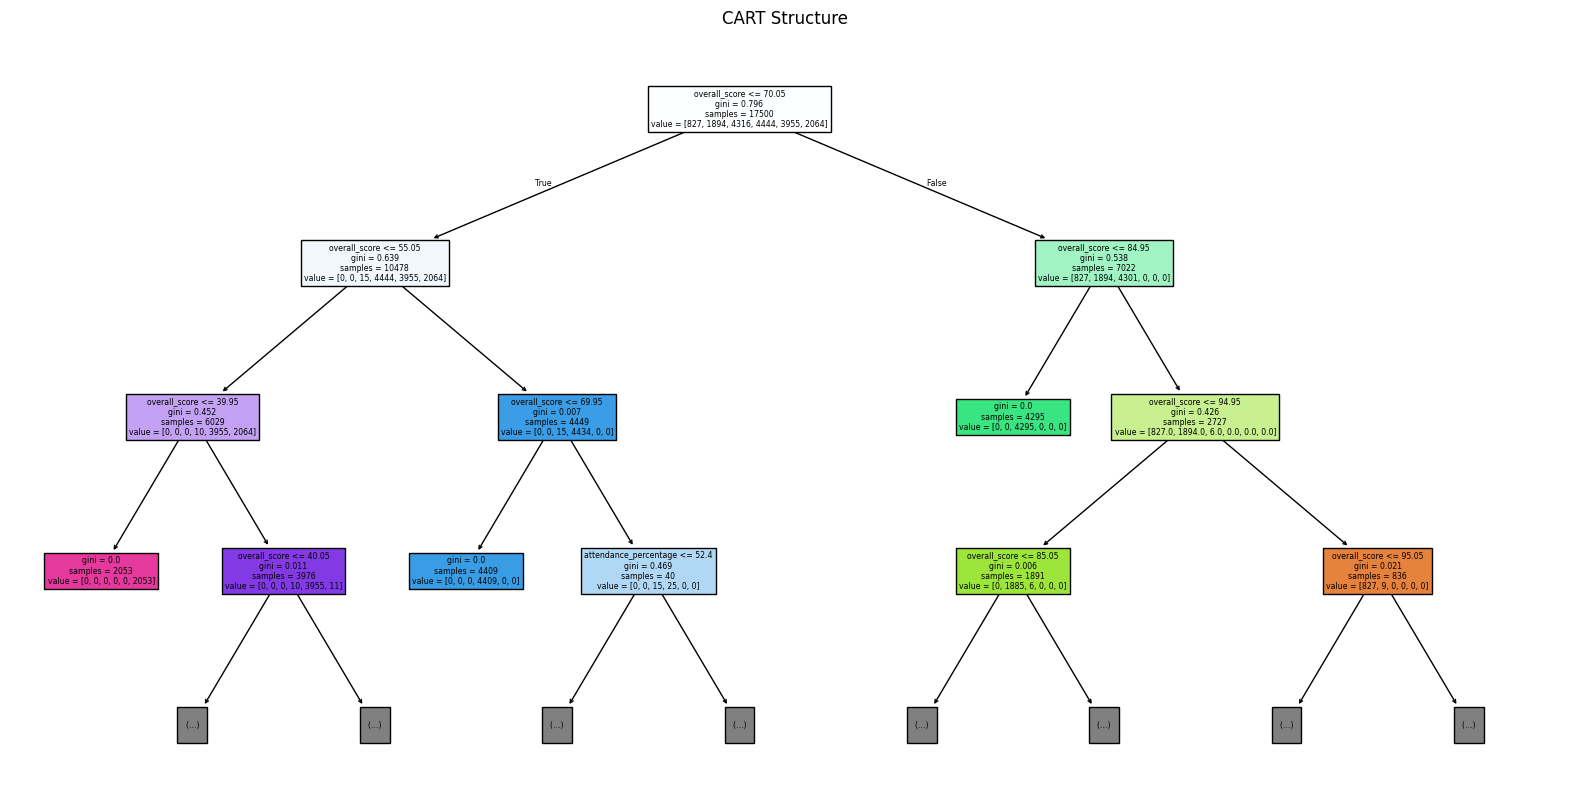

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

url = "https://raw.githubusercontent.com/mostafa-cse/Machine-Learning-Assignment/refs/heads/main/decision-tree-assignment/Student_Performance.csv"
df = pd.read_csv(url)

if 'student_id' in df.columns:
    df = df.drop(columns=['student_id'])

le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

params = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}

cart = DecisionTreeClassifier(criterion='gini', random_state=42)
gs_cart = GridSearchCV(cart, params, cv=5, scoring='accuracy')
gs_cart.fit(X_train, y_train)
best_cart = gs_cart.best_estimator_

id3 = DecisionTreeClassifier(criterion='entropy', random_state=42)
gs_id3 = GridSearchCV(id3, params, cv=5, scoring='accuracy')
gs_id3.fit(X_train, y_train)
best_id3 = gs_id3.best_estimator_

feat_cols = [X.columns.get_loc(c) for c in ['study_hours', 'attendance_percentage']]
X_v = X.iloc[:, feat_cols].values
y_v = y.values
X_tr_v, X_te_v, y_tr_v, y_te_v = train_test_split(X_v, y_v, test_size=0.3, random_state=42)

m_cart = DecisionTreeClassifier(criterion='gini', **gs_cart.best_params_).fit(X_tr_v, y_tr_v)
m_id3 = DecisionTreeClassifier(criterion='entropy', **gs_id3.best_params_).fit(X_tr_v, y_tr_v)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
def plot_db(m, x, y, a, t):
    xmin, xmax = x[:, 0].min()-1, x[:, 0].max()+1
    ymin, ymax = x[:, 1].min()-1, x[:, 1].max()+1
    xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.1), np.arange(ymin, ymax, 1.0))
    Z = m.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    a.contourf(xx, yy, Z, alpha=0.3)
    a.scatter(x[:, 0], x[:, 1], c=y, edgecolors='k', s=20, alpha=0.5)
    a.set_title(t)
plot_db(m_cart, X_te_v, y_te_v, ax[0], "CART Decision Boundary")
plot_db(m_id3, X_te_v, y_te_v, ax[1], "ID3 Decision Boundary")
plt.show()

yp_cart = best_cart.predict(X_test)
yp_id3 = best_id3.predict(X_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, yp_cart), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("CART Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, yp_id3), annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title("ID3 Confusion Matrix")
plt.show()

y_bin = label_binarize(y_test, classes=np.unique(y))
ys_cart = best_cart.predict_proba(X_test)
ys_id3 = best_id3.predict_proba(X_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
def plot_roc(y_test, y_score, ax, t):
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_score.ravel())
    ax.plot(fpr, tpr, label=f'AUC: {auc(fpr, tpr):.2f}')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_title(t)
    ax.legend()
plot_roc(y_bin, ys_cart, ax[0], "CART ROC")
plot_roc(y_bin, ys_id3, ax[1], "ID3 ROC")
plt.show()

m = {'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
     'CART': [accuracy_score(y_test, yp_cart), precision_score(y_test, yp_cart, average='weighted'),
              recall_score(y_test, yp_cart, average='weighted'), f1_score(y_test, yp_cart, average='weighted')],
     'ID3': [accuracy_score(y_test, yp_id3), precision_score(y_test, yp_id3, average='weighted'),
             recall_score(y_test, yp_id3, average='weighted'), f1_score(y_test, yp_id3, average='weighted')]}
pd.DataFrame(m).set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title("Metrics Comparison")
plt.show()

plt.figure(figsize=(20, 10))
plot_tree(best_cart, filled=True, feature_names=X.columns, max_depth=3)
plt.title("CART Structure")
plt.show()